Applied understanding of the MMM API with Kaggle Dataset

In [1]:
#set flag to fix open issue
import pytensor
pytensor.config.cxx = '/usr/bin/clang++'

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pymc_marketing.metrics import crps
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.utils import apply_sklearn_transformer_across_dim
from pymc_marketing.prior import Prior

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

### Load Data and EDA

In [17]:
data_df = pd.read_csv("marketing_mix.csv")
data_df["Date"] = pd.to_datetime(data_df["Date"])
data_df.info()
data_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        200 non-null    datetime64[ns]
 1   TikTok      200 non-null    float64       
 2   Facebook    200 non-null    float64       
 3   Google Ads  200 non-null    float64       
 4   Sales       200 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 7.9 KB


,Date,TikTok,Facebook,Google Ads,Sales
count,200,200.000000,200.000000,200.000000,200.000000
mean,2019-12-04 12:00:00,2946.207650,2213.585050,1520.722550,10668.141500
min,2018-01-07 00:00:00,0.000000,0.000000,0.000000,4532.330000
25%,2018-12-21 06:00:00,0.000000,0.000000,1657.195000,8396.942500
50%,2019-12-04 12:00:00,0.000000,0.000000,1918.990000,10853.105000
75%,2020-11-16 18:00:00,7938.527500,4624.027500,2069.767500,12566.995000
max,2021-10-31 00:00:00,13901.550000,7696.220000,2518.880000,17668.340000
std,NaN,4749.646908,2505.967886,870.764354,2700.706683


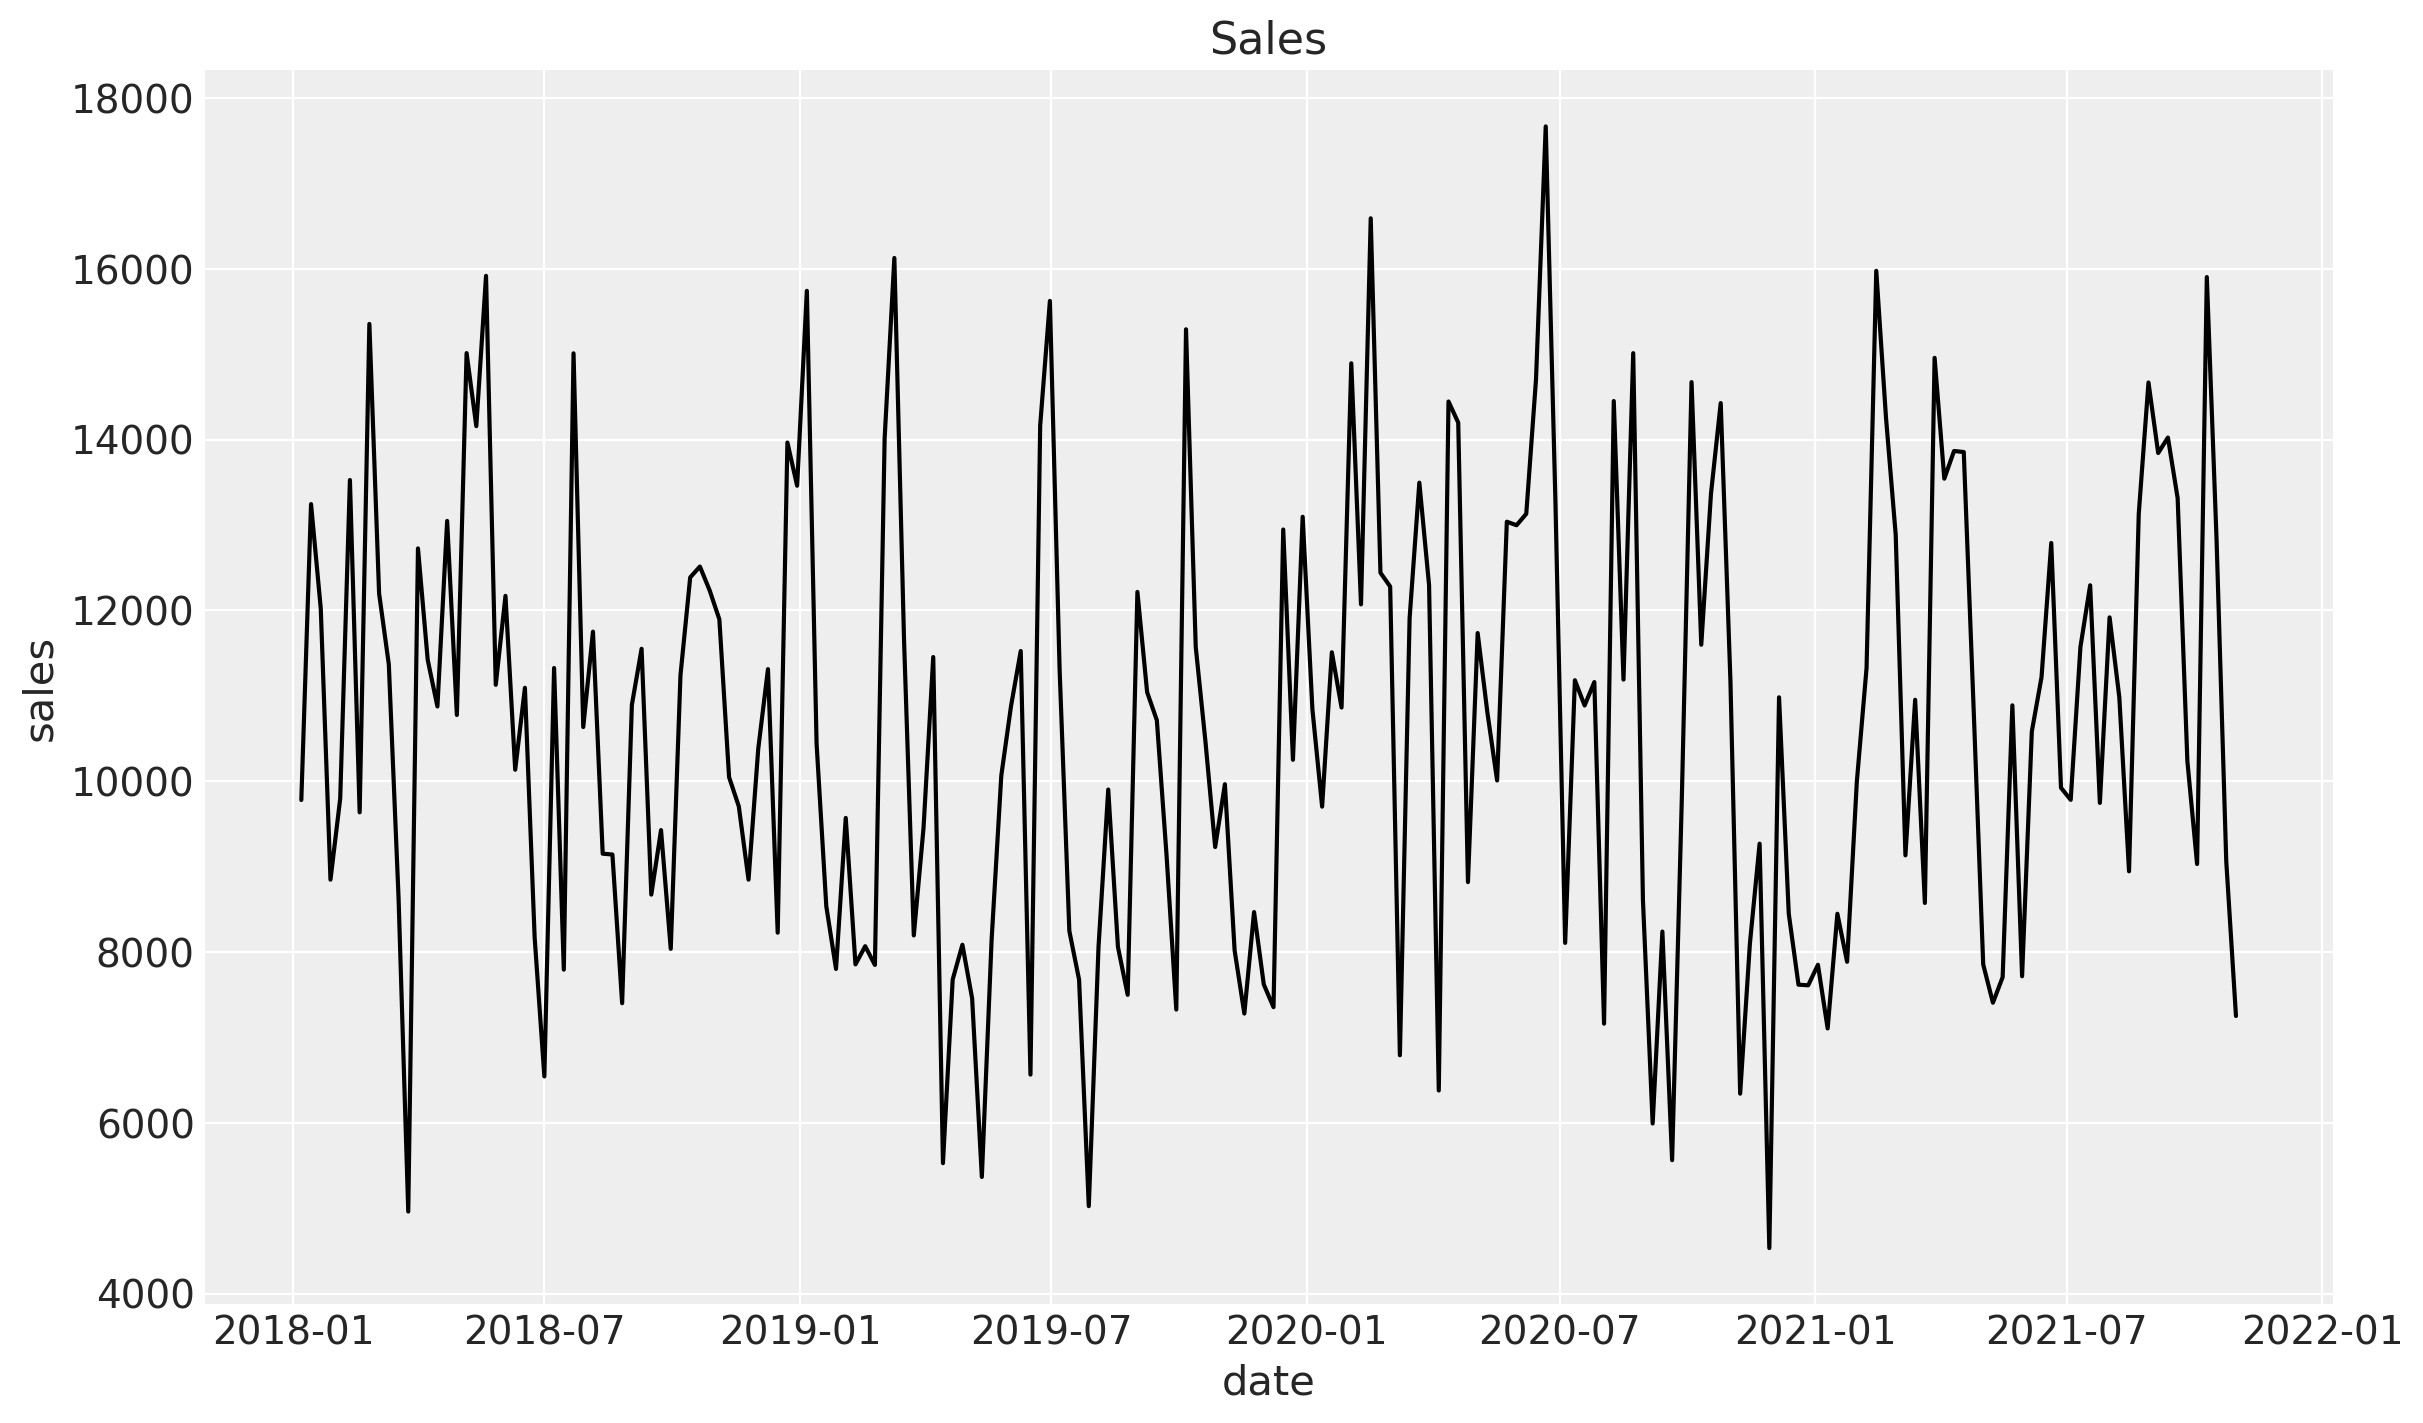

In [22]:
fig, ax = plt.subplots()
sns.lineplot(data=data_df, x="Date", y="Sales", color="black", ax=ax)
ax.set(title="Sales", xlabel="date", ylabel="sales");

No easily discernable seasonality pattern here. Let's look at marketing channel spend:

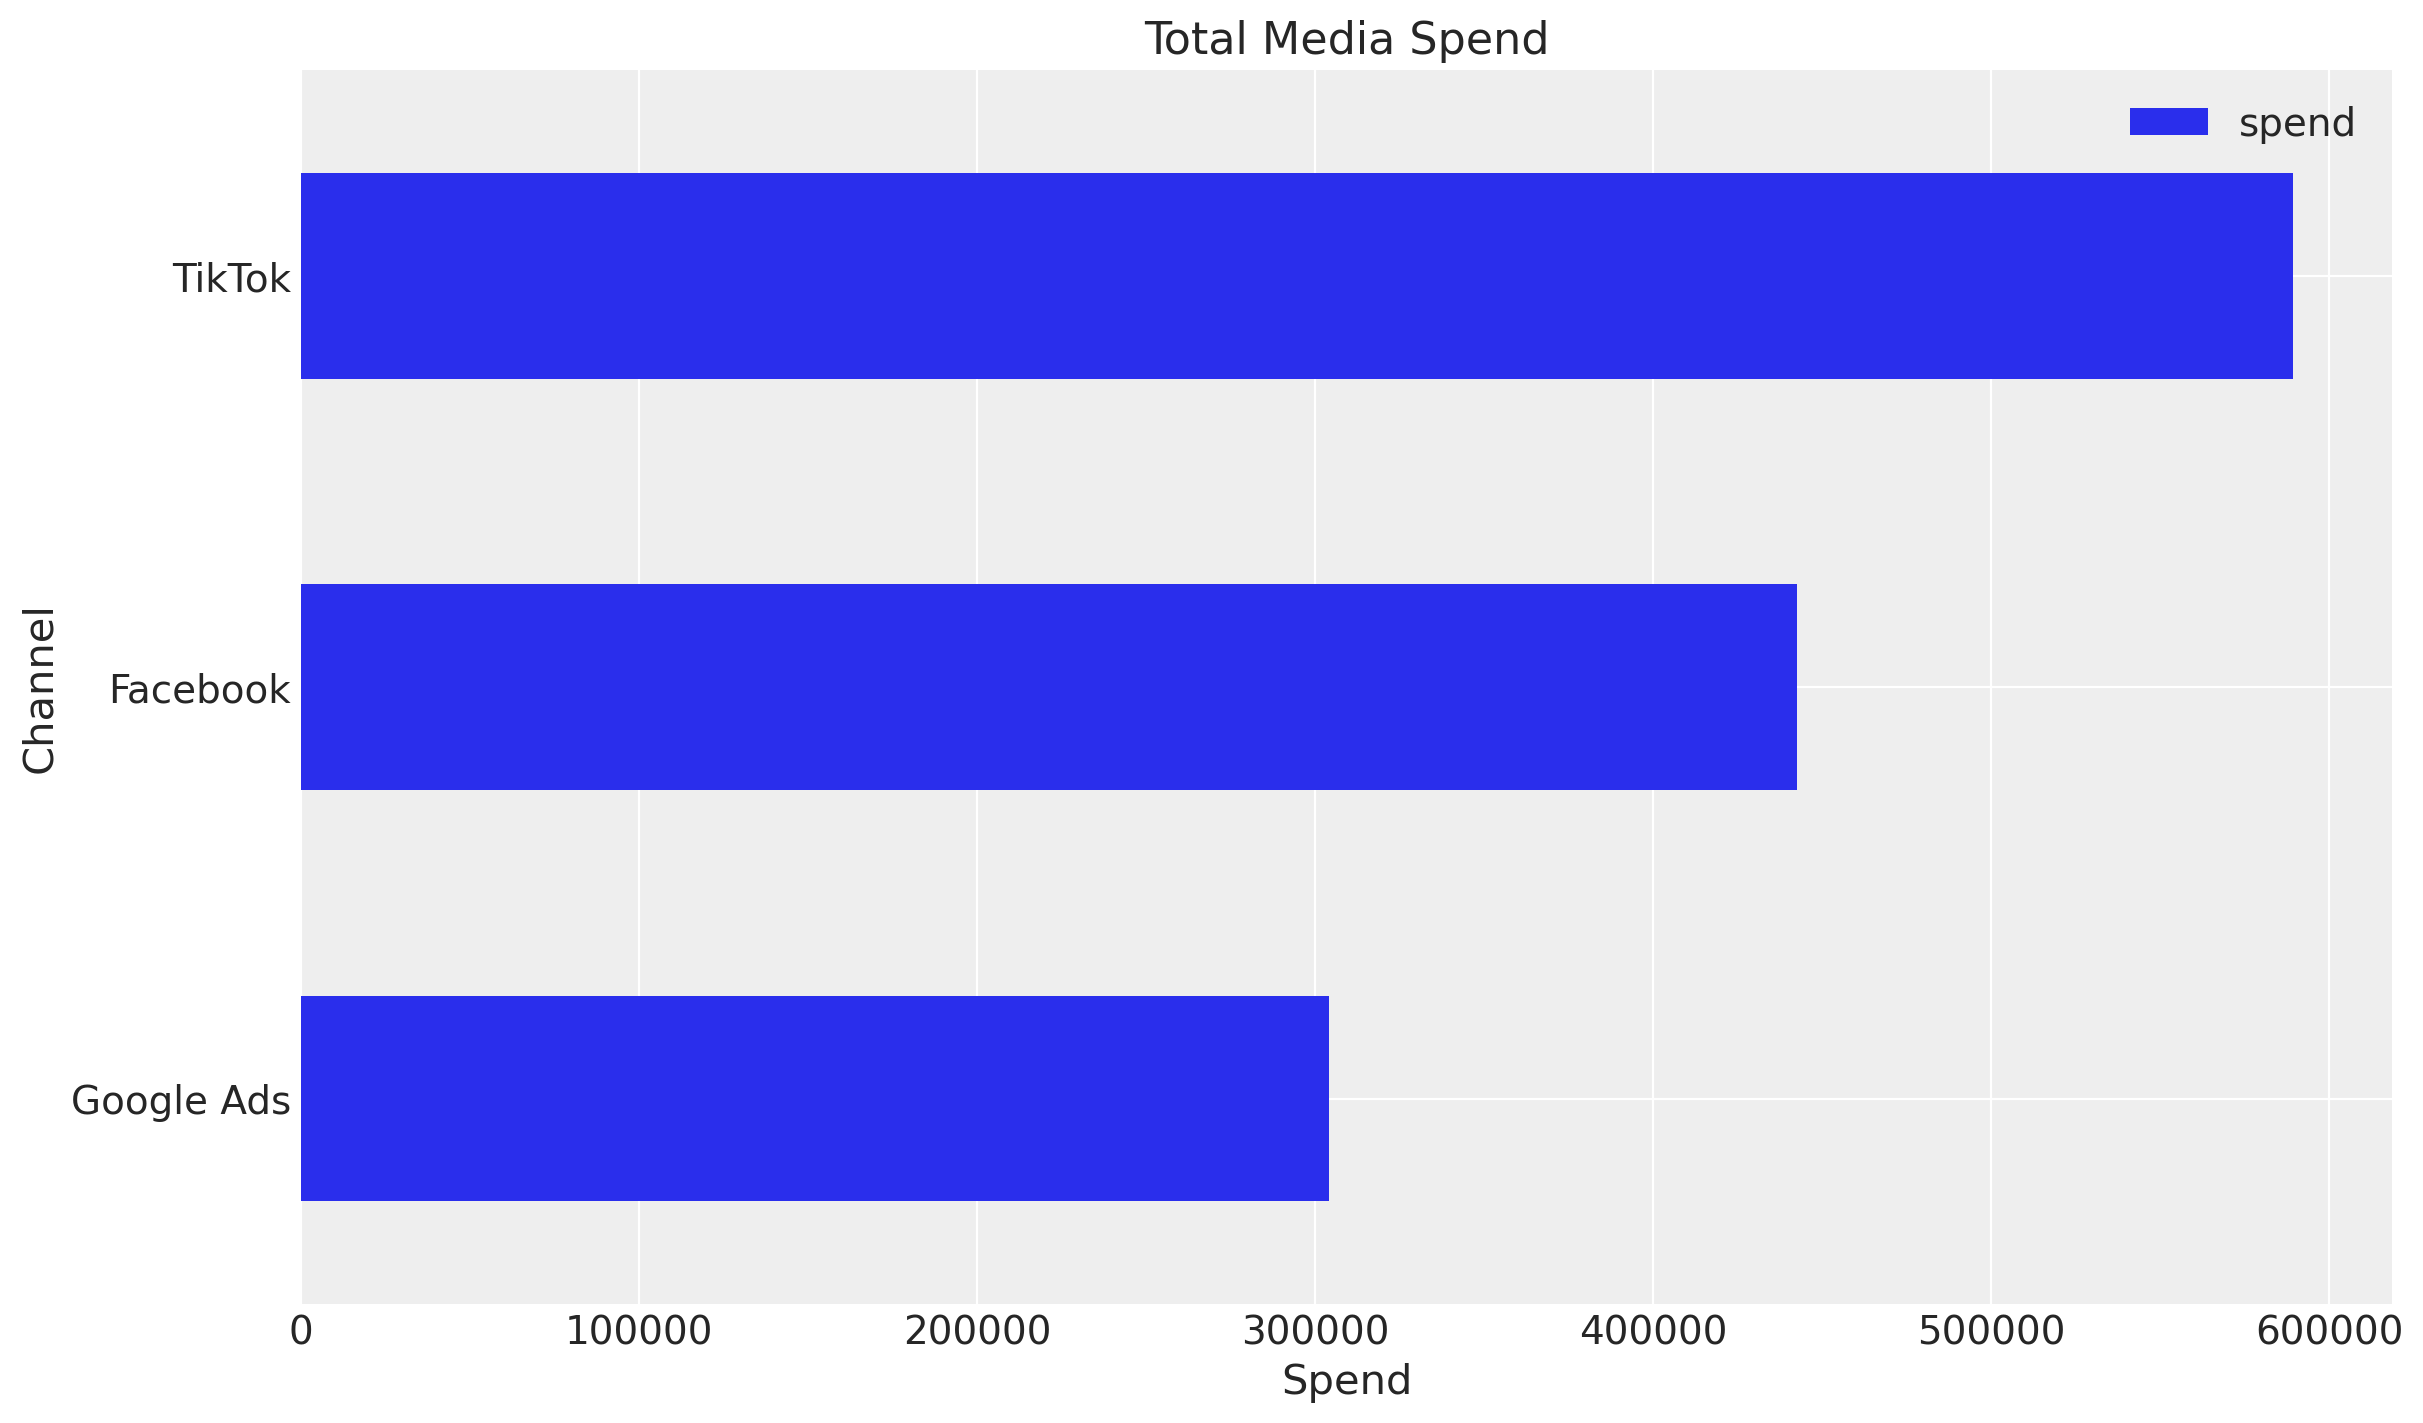

In [30]:
channel_cols = data_df.columns[1:-1]
date_col = data_df["Date"].copy()

fig, ax = plt.subplots()
data_df.melt(
    value_vars=channel_cols, var_name="channel", value_name="spend"
).groupby("channel").agg({"spend": "sum"}).sort_values(by="spend").plot.barh(ax=ax)
ax.set(title="Total Media Spend", xlabel="Spend", ylabel="Channel");

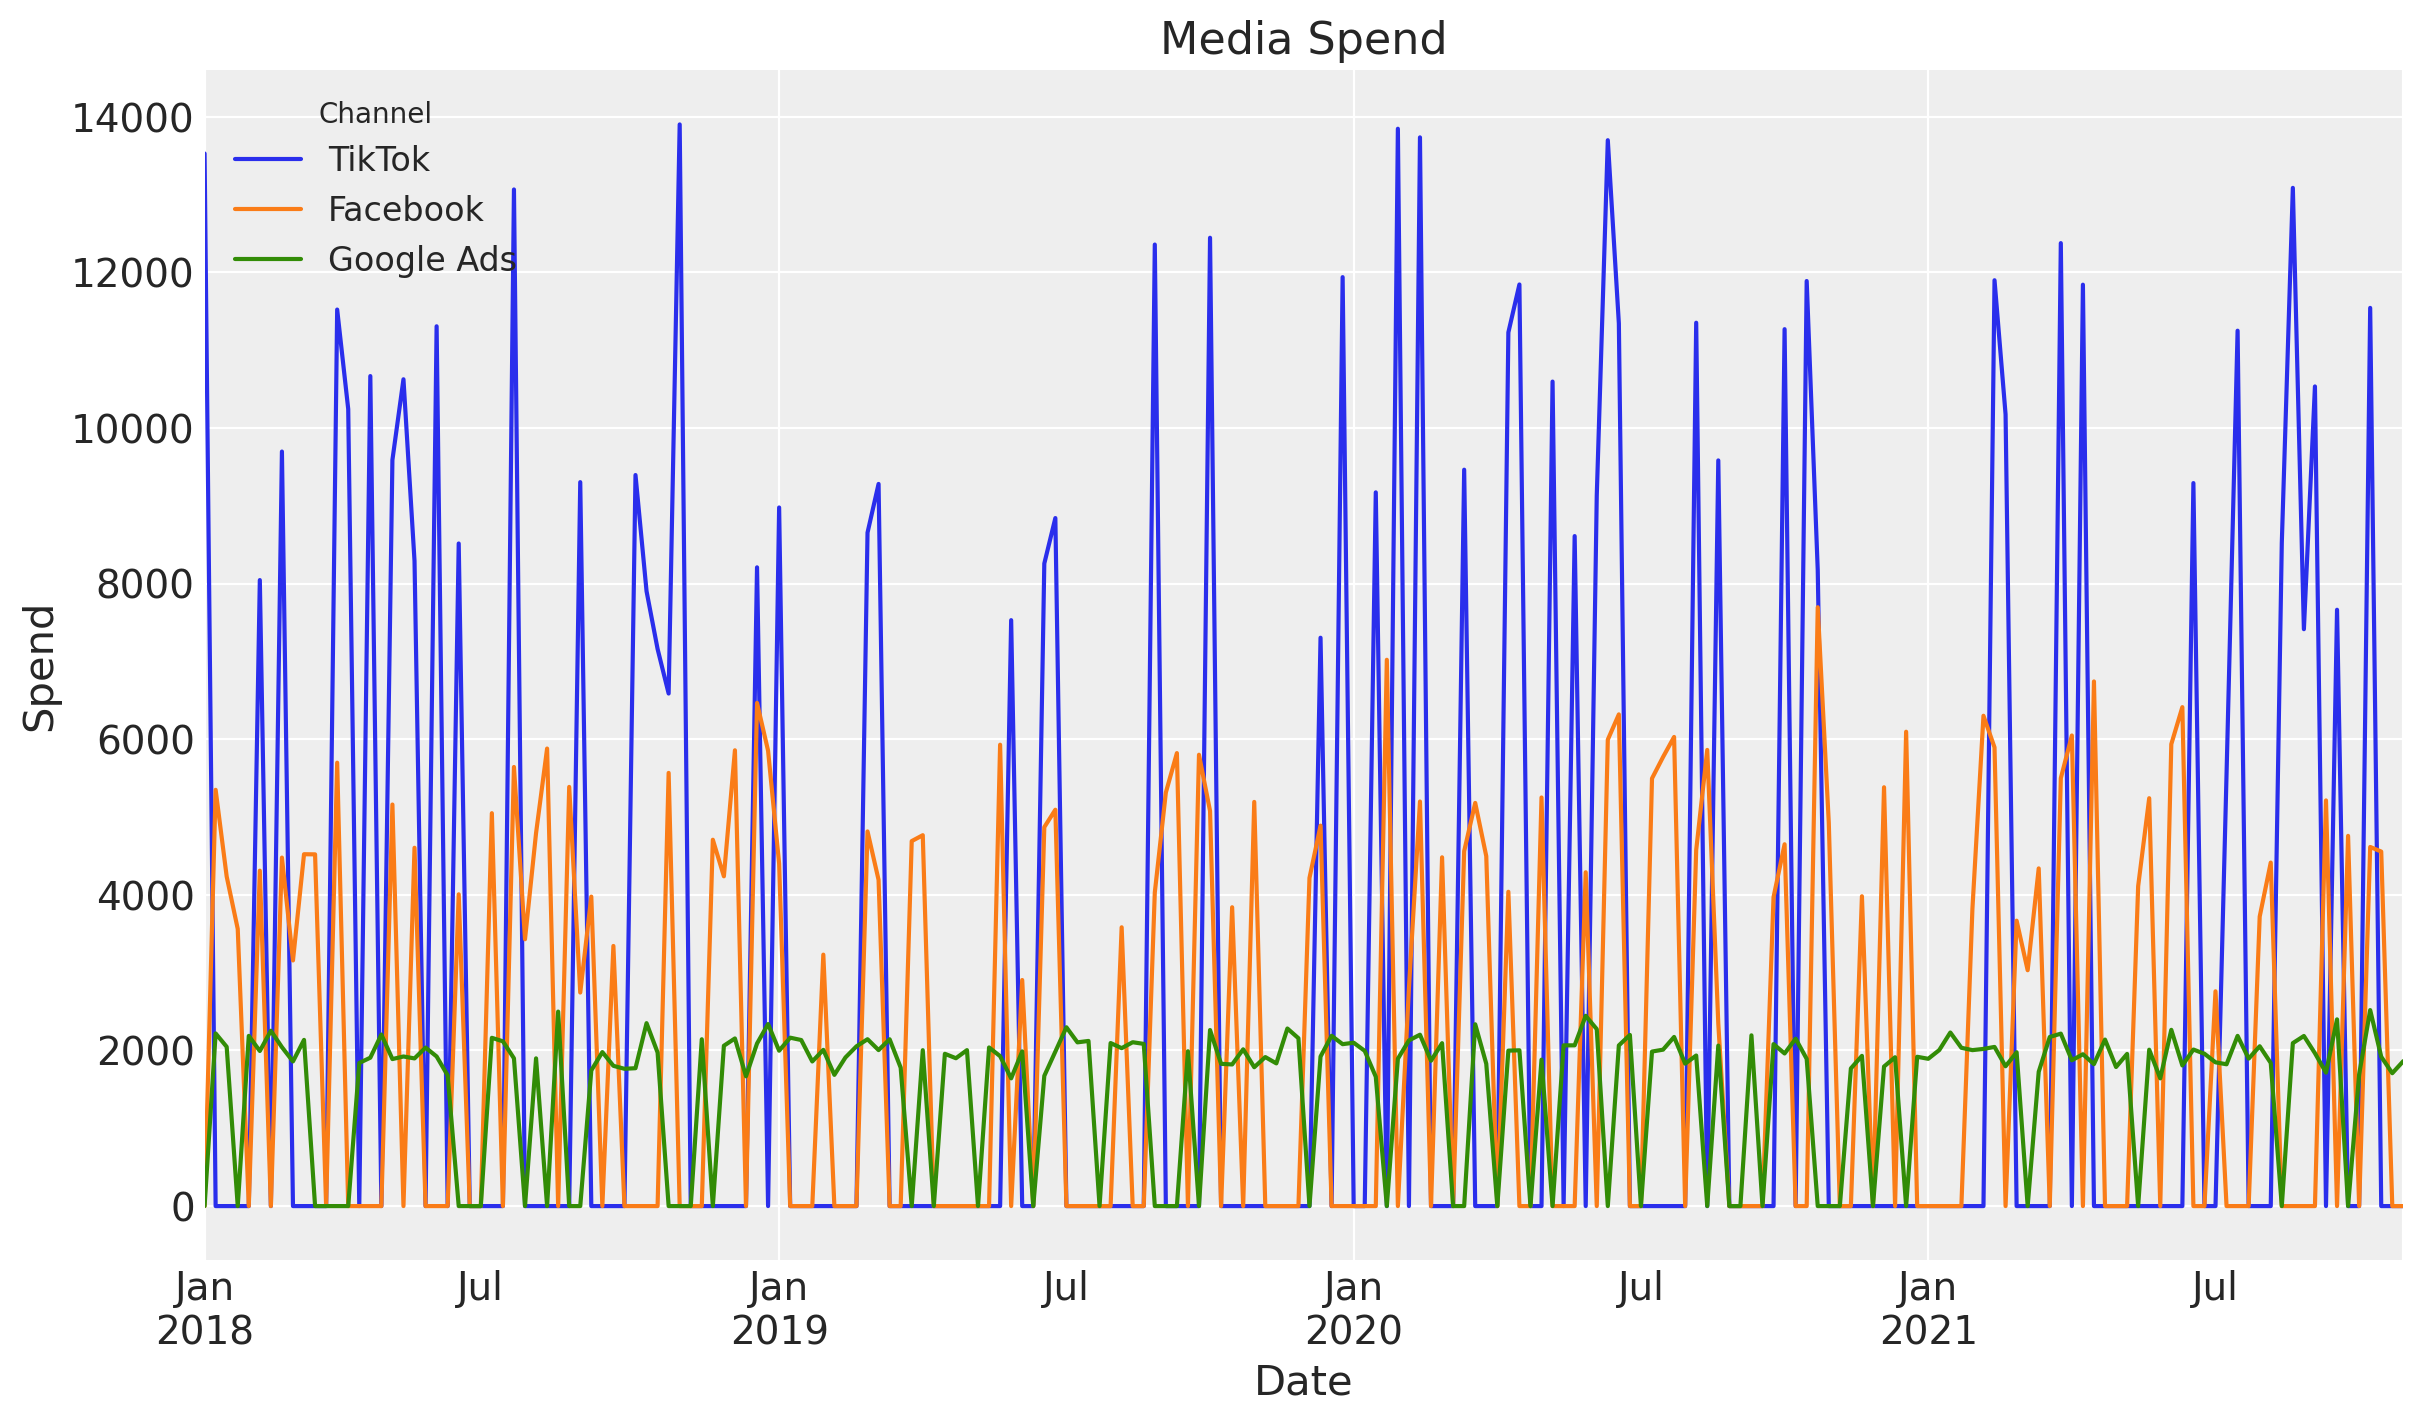

In [28]:
fig, ax = plt.subplots()
data_df.set_index("Date")[channel_cols].plot(ax=ax)
ax.legend(title="Channel", fontsize=12)
ax.set(title="Media Spend", xlabel="Date", ylabel="Spend");

Spend is fairly consistent over time for these channels, but zero spend intervals suggest some degree of seasonality.

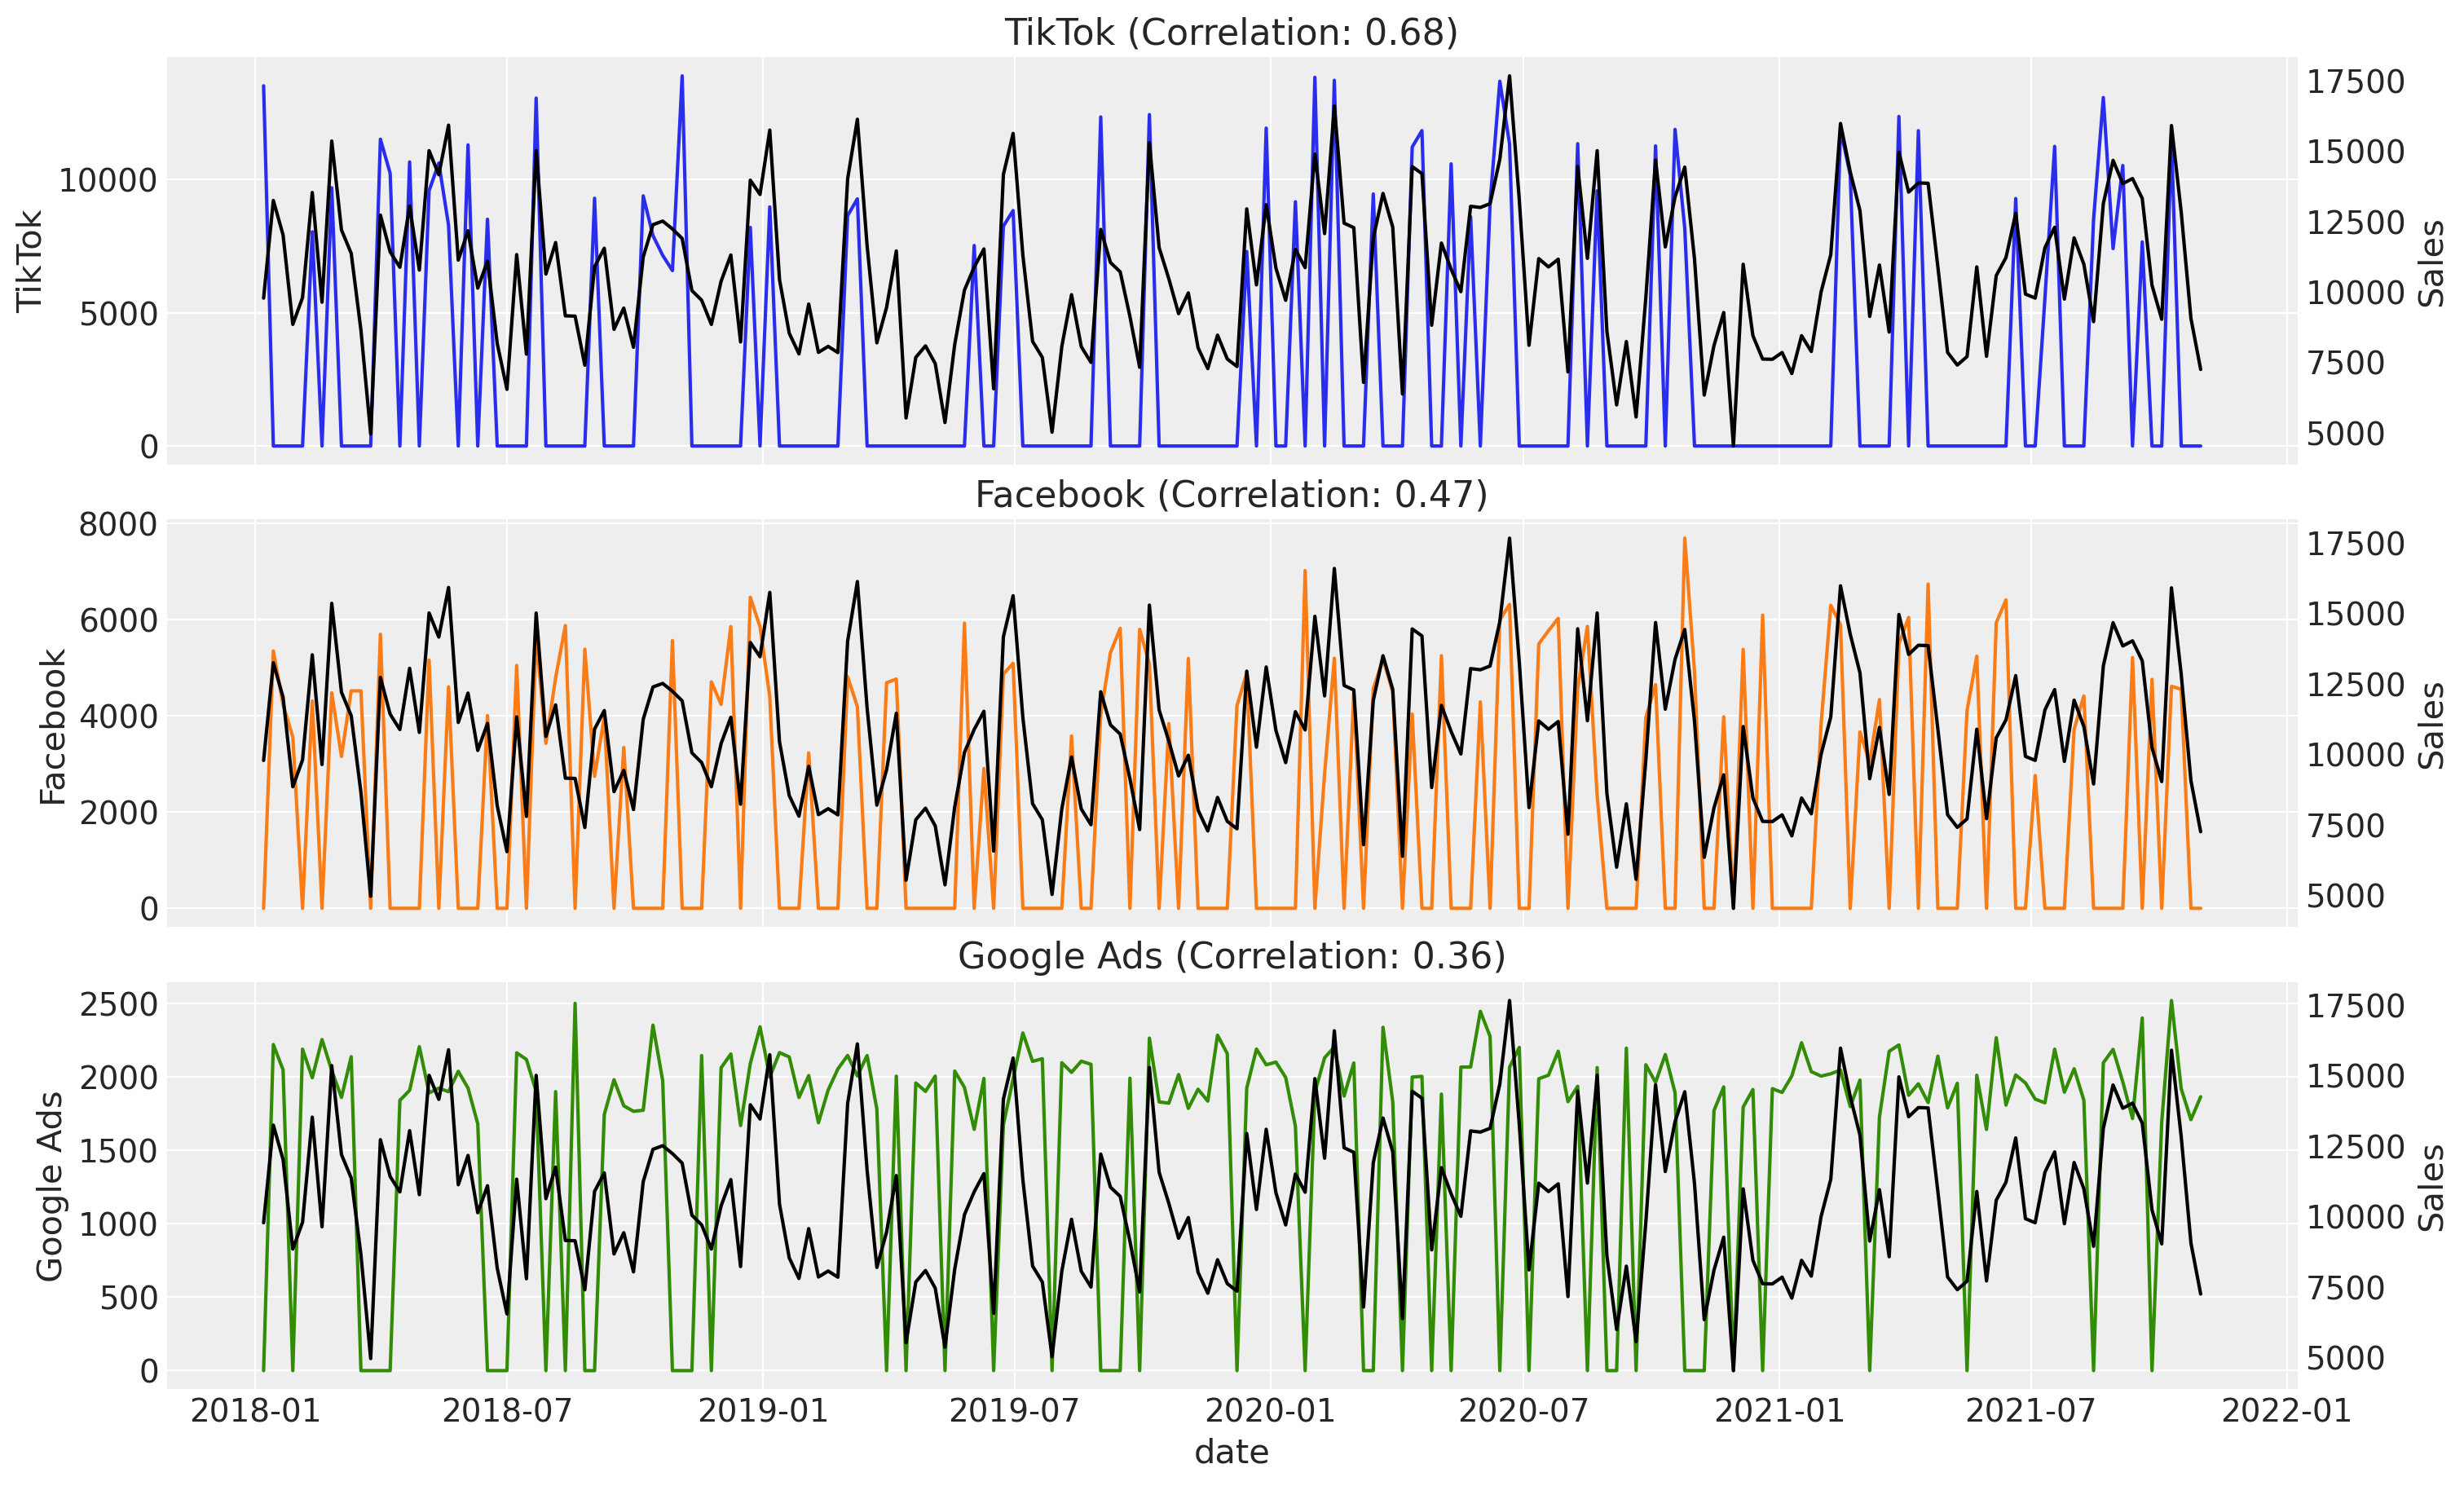

In [34]:
n_channels = len(channel_cols)

fig, axes = plt.subplots(
    nrows=n_channels,
    ncols=1,
    figsize=(15, 3 * n_channels),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for i, channel in enumerate(channel_cols):
    ax = axes[i]
    ax_twin = ax.twinx()
    sns.lineplot(data=data_df, x="Date", y=channel, color=f"C{i}", ax=ax)
    sns.lineplot(data=data_df, x="Date", y="Sales", color="black", ax=ax_twin)
    correlation = data_df[[channel, "Sales"]].corr().iloc[0, 1]
    ax_twin.grid(None)
    ax.set(title=f"{channel} (Correlation: {correlation:.2f})")

ax.set_xlabel("date");


The channel with the highest spending - TikTok - is also the most correlated with sales. It seems the greater the spend, the higher the correlation.

No significant correlation between media channels - awesome!

In [36]:
data_df[channel_cols].corr()

,TikTok,Facebook,Google Ads
TikTok,1.000000,0.084128,0.021735
Facebook,0.084128,1.000000,-0.100946
Google Ads,0.021735,-0.100946,1.000000


### Resume at Train/Test Split Section

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Tue Nov 26 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.22.2

pymc    : 5.15.1
pytensor: 2.22.1

matplotlib    : 3.8.4
seaborn       : 0.13.2
pymc          : 5.15.1
arviz         : 0.18.0
numpy         : 1.26.4
pandas        : 2.2.2
pymc_marketing: 0.10.0
xarray        : 2024.10.0

Watermark: 2.4.3

